In [8]:
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import os
%matplotlib inline

# Open fits file and assign to variable.

In [2]:
datafile = fits.open('DR7_tot_6_0.fits')

In [3]:
# Inspect fits file summary to see which dataset to use by passing .info() method on the file variable.
datafile.info()

Filename: DR7_tot_6_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    271   70841R x 127C   [I, J, I, 22A, D, D, 5E, 5E, 5E, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, I, I, I, I, I, E, E, E, E, I, E, I, E, E, D, D, D, D, E, E, E, E, E, E, D, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, I, I, I, I, I, I, I, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, I, E, E]   


In [4]:
# Assign header (dataset) in fits file to a variable. Inspect the column names by passing the .header method 
datahdr = datafile[1]
#datahdr.header

In [5]:
# Assign data columns to variables 
westplate   = datahdr.data['plate']  
westmjd     = datahdr.data['mjd']
westfiber   = datahdr.data['fiber']
westEWHA    = datahdr.data['EWHA']
westEWHAerr = datahdr.data['EWHAERR']
westRV      = datahdr.data['booRV']
westRVerr   = datahdr.data['boorv_err']

In [6]:
# Entries in these columns are 16bit integer types but want to convert them to strings in order to later assemble
# them per the sloan object id description (i.e 'spSpec-<mjd>-<plate#>-<fiber#>')
strplate = [] 
strmjd   = []
strfiber = []

for i in westplate:
    strplate.append(str(i))

for i in westmjd:
    strmjd.append(str(i))
    
for i in westfiber:
    strfiber.append(str(i))

In [9]:
# The object id fiber number is always expressed as a zero padded 4-digit number. Here I write a loop to pad
# the entries with zeros based on the entries length.
zfilledfiber = []
for i in strfiber:
    if len(i) == 2:
        i = '0' + i
    elif len(i) == 1:
        i = '00' + i
    zfilledfiber.append(i)
    
#zfilledplate = []
#for i in strplate:
#    if len(i) == 3:
#        i = i + '0' 
#    elif len(i) == 2:
#        i = i + '00'
#    elif len(i) == 1:
#        i = i + '000'
#    zfilledplate.append(i)
    
    
#print(zfilledfiber)

In [10]:
# multi-index for-loop to combine the column entries and reexpress in the form of the sloan DR7 object-id.

objectid  = []
querylist = []
for i,j,k in zip(strplate,strmjd,zfilledfiber):
    objectid.append('spSpec-' + j + '-' + i + '-' + k + '.fit')
    #querylist.append(i + ' ' + j + ' ' + k)

    #print(objectid)

In [11]:
# Now that the singular plate,mjd,and fiber columns have been correctly formatted into object id's 
# I'll then construct a simple dataframe for the Halpha equivalent widths of the west et al 2011 Mdwarf sample
# for use in comparing my equivalent width code results against.

datframe = pd.DataFrame(index=None)
datframe['DR7 OBJID']  = objectid
datframe['West2011 EWHA']    = westEWHA
datframe['West2011 EWHAerr'] = westEWHAerr

print(datframe)

                       DR7 OBJID  West2011 EWHA  West2011 EWHAerr
0      spSpec-53789-2212-356.fit       1.097070          0.225200
1      spSpec-53789-2212-489.fit       4.027402          0.893575
2      spSpec-53730-2335-185.fit      -0.071151          0.045954
3      spSpec-53733-2340-084.fit      -0.428339          0.059082
4      spSpec-53730-2335-383.fit      -0.301838          0.071948
5      spSpec-54524-2783-317.fit       0.051194          0.109005
6      spSpec-54524-2783-128.fit      -0.649438          0.290317
7      spSpec-54524-2783-098.fit       1.539945          0.654985
8      spSpec-54529-2784-092.fit       0.157208          0.102154
9      spSpec-54529-2784-006.fit       0.225640          0.170183
10     spSpec-52974-1096-510.fit       1.367151          0.384433
11     spSpec-52974-1096-495.fit      -0.164518          0.083705
12     spSpec-52974-1096-483.fit       0.265356          0.138203
13     spSpec-52974-1096-494.fit       0.158102          0.220709
14     spS

# ---------------------------------------------------------------------------------------

In [50]:
allobjtest1000 = datframe.sample(n=1000)

In [49]:
#dMs100test

In [52]:
West2011_DLlist_1000obj = allobjtest1000['Sloan Object ID'].to_csv('West2011sample1000_querylist.txt',index=False)

# ---------------------------------------------------------------------------------------

In [12]:
path = os.getcwd() + '/testEWspectra/mdwarfs/'
path

'/Users/jventura/code_abode/python/astro/EqWi/halphatest/testEWspectra/mdwarfs/'

In [11]:
for i in os.listdir(path):
    if i[-4:] == '.fit': 
        with fits.open(os.path.join(path+i)) as hdulist:
            prihdr = hdulist[0]
            obtype = prihdr.header['OBJTYPE']
            if obtype == 'STAR_RED_DWARF':
                subprocess.run(['mv', path+i , path + '/mdwarfs/']) 

In [13]:
from dr7linetools import eqwidth
from specutils.io import read_fits

In [14]:
id_rv       = []
str_rvmjd   = []
str_rvplate = []
str_rvfiber = []

for i in datahdr.data['mjd']:
    str_rvmjd.append(str(i))
    
for i in datahdr.data['plate']:
    str_rvplate.append(str(i))
    
for i in datahdr.data['fiber']:
    str_rvfiber.append(str(i))
    
zfillrvfiber = []
for i in str_rvfiber:
    if len(i) == 2:
        i = '0' + i
    elif len(i) == 1:
        i = '00' + i
    zfillrvfiber.append(i)
    


for i,j,k in zip(str_rvmjd,str_rvplate,zfillrvfiber):
    id_rv.append('spSpec-' + i + '-'+ j + '-' + k + '.fit')

In [15]:
rvcorrframe = pd.DataFrame()

rvcorrframe['DR7 OBJID'] = id_rv

rvcorrframe['BOO_RV']    = datahdr.data['BOORV'].byteswap().newbyteorder()


In [16]:
dMtestsample = []

for file in os.listdir(path):
    if file[-4:] == '.fit':
        dMtestsample.append(file)

objid_df = pd.DataFrame()
objid_df['DR7 OBJID'] = dMtestsample



dM_list_df = pd.merge (objid_df,rvcorrframe, on='DR7 OBJID')

        

In [17]:
dM_list_df    # len dM_list_df = 221

,DR7 OBJID,BOO_RV
0,spSpec-52516-1054-009.fit,-10.968637
1,spSpec-52559-1118-006.fit,-8.144330
2,spSpec-52559-1118-036.fit,-10.249235
3,spSpec-52559-1118-151.fit,-20.086290
4,spSpec-52559-1118-293.fit,-15.221969
5,spSpec-52559-1118-300.fit,-22.975876
6,spSpec-52559-1118-304.fit,-13.178253
7,spSpec-52559-1118-345.fit,-91.610077
8,spSpec-52559-1118-427.fit,23.100159
9,spSpec-52581-1119-155.fit,9.110804


In [18]:
rvcorr_jpEWHA     = []
rvcorr_jpEWHA_err = []
for filename,rv in zip(dM_list_df['DR7 OBJID'],dM_list_df['BOO_RV']):
    ew = eqwidth(os.path.join(path+filename),6555,6560,6570,6575,rv)
    rvcorr_jpEWHA.append(ew[0])
    rvcorr_jpEWHA_err.append(ew[1])
    
    #print(ew)
    

In [19]:
dM_list_df['JP EWHA (rv corrected)']       = rvcorr_jpEWHA
dM_list_df['JP EWHA Error (rv corrected)'] = rvcorr_jpEWHA_err

In [20]:
rvcorr_ewhatestdf = pd.merge(dM_list_df,datframe, on='DR7 OBJID')

In [21]:
rvcorr_ewhatestdf

,DR7 OBJID,BOO_RV,JP EWHA (rv corrected),JP EWHA Error (rv corrected),West2011 EWHA,West2011 EWHAerr
0,spSpec-52516-1054-009.fit,-10.968637,8.973895,7.304676,9.162236,4.350980
1,spSpec-52559-1118-006.fit,-8.144330,0.480607,6.776201,0.244623,0.107926
2,spSpec-52559-1118-036.fit,-10.249235,-0.352634,7.310756,-0.689383,0.200694
3,spSpec-52559-1118-151.fit,-20.086290,0.084026,3.113556,-0.017446,0.079857
4,spSpec-52559-1118-293.fit,-15.221969,-0.070667,1.046628,-0.234424,0.074556
5,spSpec-52559-1118-300.fit,-22.975876,-0.009148,6.682114,-0.093262,0.185390
6,spSpec-52559-1118-304.fit,-13.178253,-0.484305,1.681990,-0.361136,0.193079
7,spSpec-52559-1118-345.fit,-91.610077,0.329966,0.362096,0.110948,0.140841
8,spSpec-52559-1118-427.fit,23.100159,-0.419026,3.606707,-0.436678,0.068577
9,spSpec-52581-1119-155.fit,9.110804,2.490573,2.332124,2.295724,0.228429


# Below is a previous EWHA df trial... IGNORE --

In [21]:
#jpEWHA    = []
#jpEWHAerr = []
#for filename_rv in objid_df:
#    for rv in objid_df['BOO_RV']
#        ew = eqwidth(os.path.join(path+filename),6555,6560,6570,6575,)
#        jpEWHA.append(ew[0])
#        jpEWHAerr.append(ew[1])
#        #print(ew)
#        


In [28]:
os.listdir(path)[0][18:22][-1]

'.'

In [29]:
os.listdir(path)[0]

'spSpec-51882-0435-527.fit'

In [22]:
#os.listdir(path)[1:]

In [22]:
jpmjd = []
for i in os.listdir(path):
    jpmjd.append(i[7:12])
    
jpplate = []
for i in os.listdir(path):
    jpplate.append(i[13:17])
    
jpfiber = []
for i in os.listdir(path):
    if i[18:22][-1] == '.':
        jpfiber.append(i[18:21])
    elif i[18:22][-1] != '.':
        jpfiber.append(i[18:22])
            

In [23]:
jpobjid = []
for i,j,k in zip(jpplate,jpmjd,jpfiber):
    jpobjid.append('spec-' + i + '-' + j + '-' + k)
    

In [24]:
jpdf = pd.DataFrame(index=None)

In [27]:
jpdf['Sloan Object ID'] = jpobjid
jpdf['JP EWHA']         = jpEWHA
jpdf['JP EWHA Error']   = jpEWHAerr

print(jpdf)

NameError: name 'jpEWHA' is not defined

In [26]:
ewhatestdf = pd.merge(jpdf,datframe,on='Sloan Object ID')

KeyError: 'Sloan Object ID'

In [37]:
ewhatestdf

NameError: name 'ewhatestdf' is not defined

In [34]:
#x = range(1,176) ##015B63,crimson ;#6965B2,#7F7A56 ;
#plt.figure(figsize=(20,10))
#
#plt.errorbar(x,ewhatestdf['West2011 EWHA'],yerr= ewhatestdf['West2011 EWHAerr'],c='#0D4563',ms=8,alpha=0.6,fmt = '.')
##plt.plot(x,ewhatestdf['West2011 EWHA'], linestyle=None)
#
#plt.errorbar(x,ewhatestdf['JP EWHA'],yerr = ewhatestdf['JP EWHA Error'],c='crimson',ms=8,alpha=.6,fmt='.')
##plt.plot(x,ewhatestdf['JP EWHA'],linestyle=None)
##plt.plot(ewhatestdf['West2011 EWHA'],'teal')
#
#
#plt.title('$West$ $2011$ $v$ $JP$ $EW$ $H\\alpha$ $Comparison$', fontsize=22)
#plt.ylim(-20,45)
#plt.xlabel('$dM$ $Sample$ $[N]$', fontsize=18)
#plt.xticks(fontsize=14)
#plt.ylabel('$EWHA$ $[\AA]$',fontsize=18)
#plt.yticks(fontsize=14)
#plt.legend(fontsize=18)
#plt.savefig('west11vjp.png', dpi=100)
#plt.show()

In [43]:
# my errors seem large generally which is fine, but i want to see if my code is truly
# calculating things right. Here I print the first 5 rows of the dataframe so that i can see the colum headers and 
# then select on particular values.
ewhatestdf.head()

,Sloan Object ID,JP EWHA,JP EWHA Error,West2011 EWHA,West2011 EWHAerr,West2011 RV,west2011 RV_ERR
0,spec-1118-52559-151,-0.123707,3.626971,-0.017446,0.079857,-20.086290,2.336159
1,spec-1118-52559-293,-0.187906,1.870786,-0.234424,0.074556,-15.221969,6.483954
2,spec-1118-52559-300,-0.195363,6.619920,-0.093262,0.185390,-22.975876,7.195209
3,spec-1118-52559-304,-0.137641,0.346760,-0.361136,0.193079,-13.178253,7.514291
4,spec-1118-52559-345,0.024131,2.219535,0.110948,0.140841,-91.610077,5.138800


In [20]:
hdu1 = fits.open(os.path.join(path + 'spSpec-52762-1309-476.fit'))
prihdr1 = hdu1[0]
    # Define wavelength and flux arrays by accessing .fits sloan data
lmbda1 = []
flux1  = prihdr1.data[0]
for i in range(0,prihdr1.header['NAXIS1']):
    wlenvalue1 = 10**np.array(prihdr1.header['COEFF0'] + (prihdr1.header['COEFF1'] * i))
    lmbda1.append(wlenvalue1)

lmbda01 = np.array(lmbda1)

normindex = np.where((lmbda01 >= 8250) & (lmbda01 <= 8350))
avgval1 = np.mean(flux1[normindex])
nflux1 = flux1/avgval1  # changed to np array, test to see if it
                                   # makes a difference...

continuumindex1 = np.where(((lmbda01 >= 6555) & (lmbda01 <= 6560)) | ((lmbda01 >= 6570) & (lmbda01 <= 6575)))
lineindex1 = np.where((lmbda01 >= 6560) & (lmbda01 <= 6570))


x1 = lmbda01[continuumindex1]
y1 = nflux1[continuumindex1]

m1,c1 = np.polyfit(x1,y1,1)
fitline1 = m1 * lmbda01 + c1    

plt.figure(figsize = (20,8))    
plt.plot(lmbda01,nflux1,label = 'spSpec-52762-1309-476.fit')
plt.plot(lmbda01,fitline1[lineindex1], label = "pseudocontinuum")
plt.xlim(6500,6600)
plt.legend()
plt.text(6557,1.5,'EWHA = ' + str(ha1), fontsize = 14)
plt.show()

        
        








hdu2 = fits.open(os.path.join(path + 'spSpec-53228-1728-572.fit'))
prihdr2 = hdu2[0]
    # Define wavelength and flux arrays by accessing .fits sloan data
lmbda2 = []
flux2  = prihdr2.data[0]
for i in range(0,prihdr2.header['NAXIS1']):
    wlenvalue2 = 10**np.array(prihdr2.header['COEFF0'] + (prihdr2.header['COEFF1'] * i))
    lmbda2.append(wlenvalue2)

lmbda02 = np.array(lmbda2)

# Normalize flux by dividing flux array by mean flux value over relatively quiet continuum region

normindex2 = np.where((lmbda02 >= 8250) & (lmbda02 <= 8350))
avgval2 = np.mean(flux2[normindex])
nflux2 = flux2/avgval2  

continuumindex2 = np.where(((lmbda02 >= 6555) & (lmbda02 <= 6560)) | ((lmbda02 >= 6570) & (lmbda02 <= 6575)))
lineindex2 = np.where((lmbda02 >= 6560) & (lmbda02 <= 6570))

x2 = lmbda02[continuumindex2]
y2 = nflux2[continuumindex2]

m2,c2 = np.polyfit(x2,y2,1)
fitline2 = m2 * lmbda02 + c2

plt.figure(figsize = (20,8))
plt.plot(lmbda02,nflux2,label = 'spSpec-53228-1728-572.fit')
plt.plot(lmbda02,fitline2[lineindex2], label = "pseudocontinuum")
plt.xlim(6500,6600)
plt.legend()
plt.text(6557,1.5,'EWHA = ' + str(ha2),fontsize = 14)
plt.show()



ValueError: x and y must have same first dimension, but have shapes (3853,) and (6,)

In [69]:
ha1 = eqwidth(os.path.join(path+'spSpec-52762-1309-476.fit'),6555,6560,6570,6575)
ha2 = eqwidth(os.path.join(path+'spSpec-53228-1728-572.fit'),6555,6560,6570,6575)

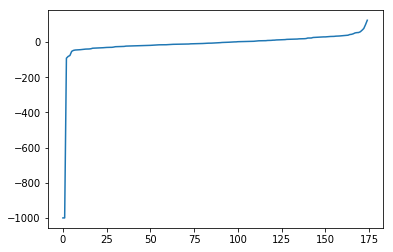

In [55]:
westjpdiff =  ewhatestdf['West2011 EWHA'] - ewhatestdf['JP EWHA']

plt.show(plt.plot(np.sort(ewhatestdf['West2011 RV'])))

In [25]:
c = np.polyfit(ewhatestdf['West2011 EWHA'],ewhatestdf['JP EWHA'],1)
d = np.poly1d(c)
print(c,d)

[ 0.68124763 -0.01990715]  
0.6812 x - 0.01991


In [26]:
west      = np.sort(ewhatestdf['West2011 EWHA'])
westindex = np.argsort(ewhatestdf['West2011 EWHA'])
westerr   = ewhatestdf['West2011 EWHAerr'][westindex]

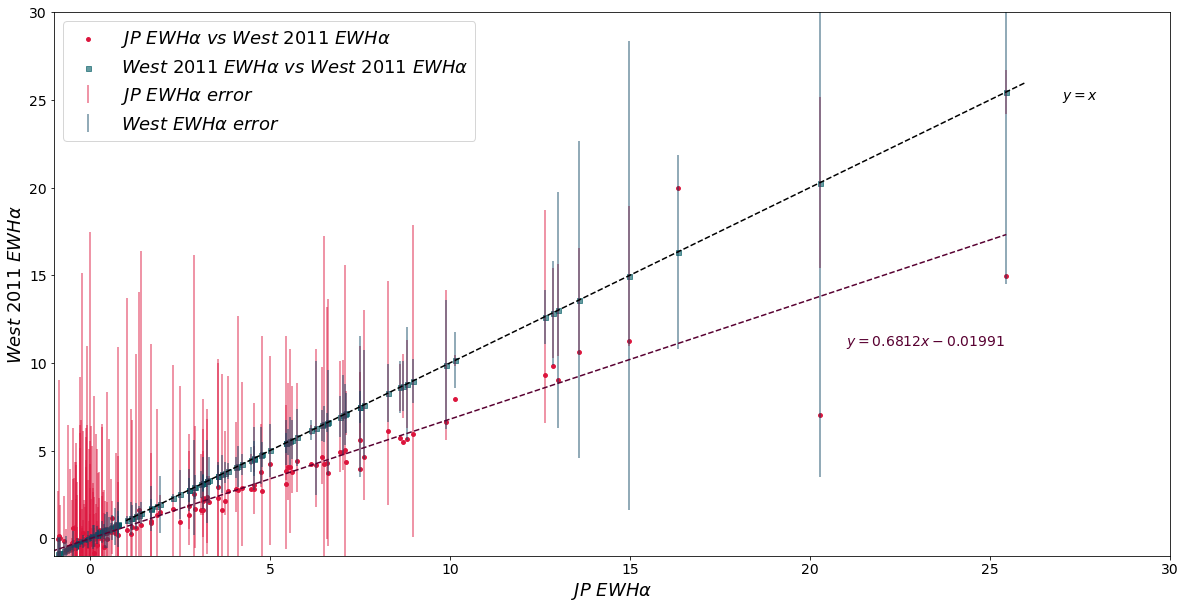

In [27]:
plt.figure(figsize=(20,10))

plt.scatter(ewhatestdf['West2011 EWHA'],ewhatestdf['JP EWHA'],s=15,c='crimson', label = '$JP$ $EWH\\alpha$ $vs$ $West$ $2011$ $EWH\\alpha$')
plt.errorbar(west,west,xerr = None,yerr = ewhatestdf['JP EWHA Error'],color ='crimson',ls='none', label = '$JP$ $EWH\\alpha$ $error$',alpha=0.6)

plt.scatter(west,west,s=25,c='#015B63',marker='s',alpha = 0.6,label = '$West$ $2011$ $EWH\\alpha$ $vs$ $West$ $2011$ $EWH\\alpha$')
plt.errorbar(west,west,xerr = None,yerr = westerr,color ='#0D4563',ls='none', label = '$West$ $EWH\\alpha$ $error$',alpha=0.6)

plt.plot(west,d(west),c='#580031',linestyle='--')
plt.plot([1,26],[1,26],c='k',linestyle='--')


plt.xlim(-1,30)
plt.ylim(-1,30)
plt.text(27,25,'$y=x$',fontsize = 14)
plt.text(21,11,'$y = 0.6812 x - 0.01991$',color='#580031', fontsize=14 )
plt.legend(fontsize=18,loc=2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.xlabel('$JP$ $EWH\\alpha$', fontsize = 18)
plt.ylabel('$West$ $2011$ $EWH\\alpha$',fontsize = 18)
plt.savefig('jpEWHAvWest2011EWHA316.png', dpi=100)
plt.show()



#  Above is a previous EWHA df trial... IGNORE

In [33]:
len(range(1,222))

221

In [28]:
rvcorr_ewhatestdf.head(5)

,DR7 OBJID,BOO_RV,JP EWHA (rv corrected),JP EWHA Error (rv corrected),West2011 EWHA,West2011 EWHAerr
0,spSpec-52516-1054-009.fit,-10.968637,8.973895,7.304676,9.162236,4.350980
1,spSpec-52559-1118-006.fit,-8.144330,0.480607,6.776201,0.244623,0.107926
2,spSpec-52559-1118-036.fit,-10.249235,-0.352634,7.310756,-0.689383,0.200694
3,spSpec-52559-1118-151.fit,-20.086290,0.084026,3.113556,-0.017446,0.079857
4,spSpec-52559-1118-293.fit,-15.221969,-0.070667,1.046628,-0.234424,0.074556


In [34]:
#x = range(1,176) ##015B63,crimson ;#6965B2,#7F7A56 ;
#plt.figure(figsize=(20,10))
#
#plt.errorbar(x,ewhatestdf['West2011 EWHA'],yerr= ewhatestdf['West2011 EWHAerr'],c='#0D4563',ms=8,alpha=0.6,fmt = '.')
##plt.plot(x,ewhatestdf['West2011 EWHA'], linestyle=None)
#
#plt.errorbar(x,ewhatestdf['JP EWHA'],yerr = ewhatestdf['JP EWHA Error'],c='crimson',ms=8,alpha=.6,fmt='.')
##plt.plot(x,ewhatestdf['JP EWHA'],linestyle=None)
##plt.plot(ewhatestdf['West2011 EWHA'],'teal')
#
#
#plt.title('$West$ $2011$ $v$ $JP$ $EW$ $H\\alpha$ $Comparison$', fontsize=22)
#plt.ylim(-20,45)
#plt.xlabel('$dM$ $Sample$ $[N]$', fontsize=18)
#plt.xticks(fontsize=14)
#plt.ylabel('$EWHA$ $[\AA]$',fontsize=18)
#plt.yticks(fontsize=14)
#plt.legend(fontsize=18)
#plt.savefig('west11vjp.png', dpi=100)
#plt.show()

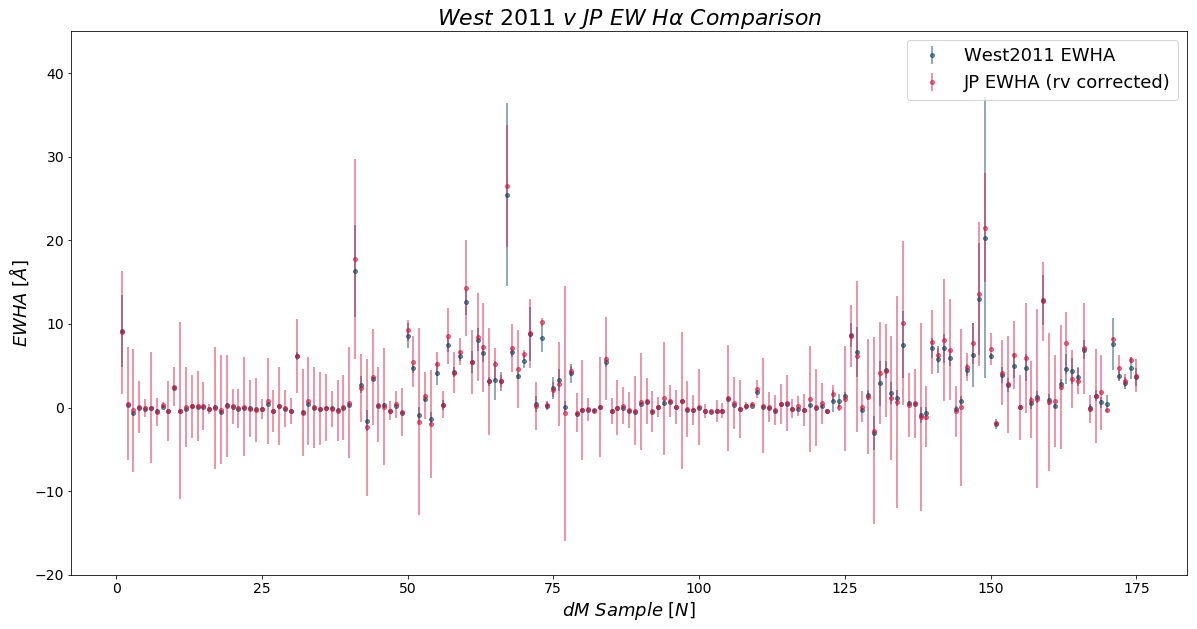

In [29]:
x = range(1,176) ##015B63,crimson ;#6965B2,#7F7A56 ;
plt.figure(figsize=(20,10))

plt.errorbar(x,rvcorr_ewhatestdf['West2011 EWHA'][0:175],yerr= rvcorr_ewhatestdf['West2011 EWHAerr'][0:175],c='#0D4563',ms=8,alpha=0.6,fmt = '.')
#plt.plot(x,ewhatestdf['West2011 EWHA'], linestyle=None)

plt.errorbar(x,rvcorr_ewhatestdf['JP EWHA (rv corrected)'][0:175],yerr = rvcorr_ewhatestdf['JP EWHA Error (rv corrected)'][0:175],c='crimson',ms=8,alpha=.6,fmt='.')
#plt.plot(x,ewhatestdf['JP EWHA'],linestyle=None)
#plt.plot(ewhatestdf['West2011 EWHA'],'teal')


plt.title('$West$ $2011$ $v$ $JP$ $EW$ $H\\alpha$ $Comparison$', fontsize=22)
plt.ylim(-20,45)
plt.xlabel('$dM$ $Sample$ $[N]$', fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('$EWHA$ $[\AA]$',fontsize=18)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.savefig('west11vjp_rvcorr.png', dpi=100)
plt.show()

In [24]:
c = np.polyfit(rvcorr_ewhatestdf['West2011 EWHA'],rvcorr_ewhatestdf['JP EWHA (rv corrected)'],1)
d = np.poly1d(c)
print(c,d)

[ 1.05688954  0.01950954]  
1.057 x + 0.01951


In [25]:
west      = np.sort(rvcorr_ewhatestdf['West2011 EWHA'][0:175])
westindex = np.argsort(rvcorr_ewhatestdf['West2011 EWHA'][0:175])
westerr   = rvcorr_ewhatestdf['West2011 EWHAerr'][westindex]

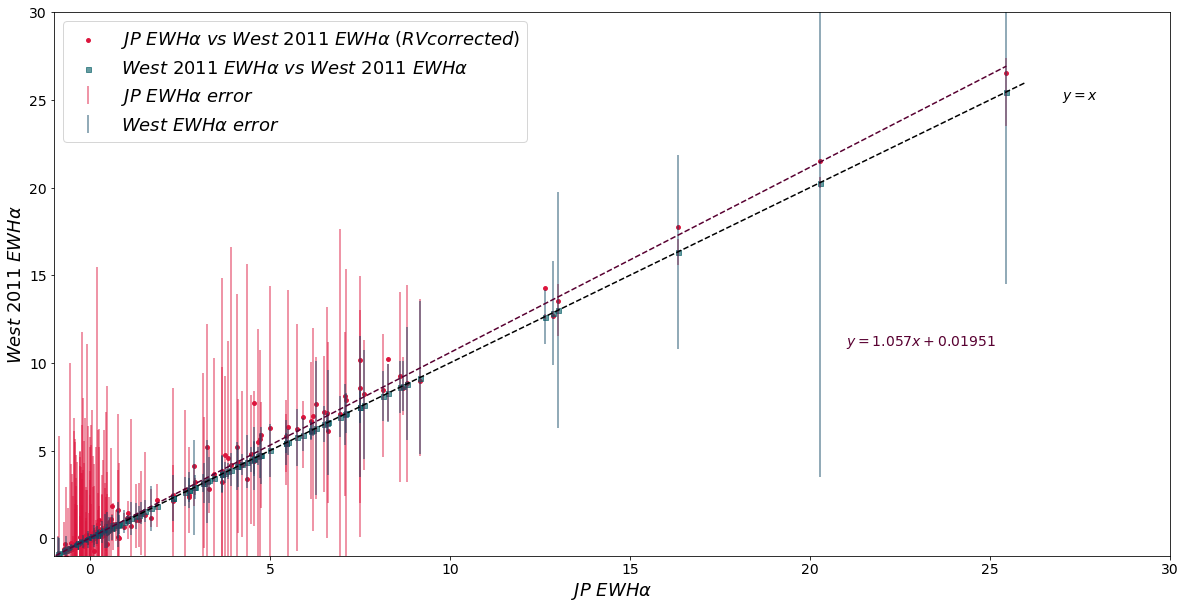

In [26]:
plt.figure(figsize=(20,10))

plt.scatter(rvcorr_ewhatestdf['West2011 EWHA'][0:175],rvcorr_ewhatestdf['JP EWHA (rv corrected)'][0:175],s=15,c='crimson', label = '$JP$ $EWH\\alpha$ $vs$ $West$ $2011$ $EWH\\alpha$ $(RV corrected)$')
plt.errorbar(west,west,xerr = None,yerr = rvcorr_ewhatestdf['JP EWHA Error (rv corrected)'][0:175],color ='crimson',ls='none', label = '$JP$ $EWH\\alpha$ $error$',alpha=0.6)

plt.scatter(west,west,s=25,c='#015B63',marker='s',alpha = 0.6,label = '$West$ $2011$ $EWH\\alpha$ $vs$ $West$ $2011$ $EWH\\alpha$')
plt.errorbar(west,west,xerr = None,yerr = westerr,color ='#0D4563',ls='none', label = '$West$ $EWH\\alpha$ $error$',alpha=0.6)

plt.plot(west,d(west),c='#580031',linestyle='--')
plt.plot([1,26],[1,26],c='k',linestyle='--')


plt.xlim(-1,30)
plt.ylim(-1,30)
plt.text(27,25,'$y=x$',fontsize = 14)
plt.text(21,11,'$y = 1.057 x + 0.01951$',color='#580031', fontsize=14 )
plt.legend(fontsize=18,loc=2)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.xlabel('$JP$ $EWH\\alpha$', fontsize = 18)
plt.ylabel('$West$ $2011$ $EWH\\alpha$',fontsize = 18)
plt.savefig('jpEWHA_rvcorrvWest2011EWHA.png', dpi=100)
plt.show()

